# PROJECT 10 인물사진을 만들어 보자

## 1 인물사진 모드란?

인물 사진 모드는 듀얼 카메라를 이용하 DSLR의 아웃포커싱을 흉내낸다. 쉽게 말해 피사체를 찍을때, 피사체에만 초점을 맞추고 배경을 흐릿한다.

한국에서는 배경을 흐리게 하는 기술을 '아웃포커싱' 이라고 표현합니다.  
하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 **얕은 피사계 심도(shallow depth of field)** 또는 **셸로우 포커스(shallow focus)** 라고 합니다.

## 2 셸로우 포커스 만들기

### 2.1 환경 준비하기

실습을 위한 폴더를 만듭니다.  

```$ mkdir -p ~/폴더명/human_segmentation/models```  
```$ mkdir -p ~/폴더명/human_segmentation/images```

### 2.2 사진 준비하기

> **하나의 카메라로 셸로우 포커스를 만드는 방법**  
>    1. 배경이 있는 셀카를 촬영합니다.  
>    2. 시멘틱 세그멘테이션(Sementic segmentaion)으로 피사체(사람)와 배경을 분리합니다.  
>    3. 블러링(bluring) 기술로 배경을 흐리게 합니다.  
>    4. 피사체를 배경의 원래 위치에 합성합니다.

먼저 오늘 사용할 패키지를 불러옵니다.  

```$ pip install opencv-python```

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

준비한 이미지를 읽습니다.

In [2]:
img_path = os.getenv("HOME") + "/aiffel/exploration/human_segmentation/images"


img1_orig = cv2.imread(img_path + '/V.jpg')

print(f'img1_orig shape : {img1_orig.shape}')

img1_orig shape : (727, 700, 3)


### 2.3 세그멘테이션으로 사람 분리하기

> **이미지 세그멘테이션(image segmentation) 이란?**  
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다.  

> **시멘틱 세그멘테이션(semantic segmentation) 이란?**  
세그멘테이션 중에서도 물리적 의미 단위로 인식하는 세그멘테이션을 시멘틱 세그멘테이션(semantic segmentation) 이라고 합니다.  
쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하는 방법이라고 이해하시면 됩니다.  

> **인스턴스 세그멘테이션(instance segmentation) 이란?**  
시멘틱 세그멘테이션은 '사람' 이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계 없이 같은 라벨로 표현됩니다.  더 나아가서 인스턴스 세그멘테이션은 사람 개개인 별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.  


![이미지](images/이미지.png)
![이미지](images/이미지2.png)
$$ 인스턴스\,세그멘테이션(좌), \,시멘틱\,세그멘테이션(우)$$
이미지 출처 : https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb

### 2.4 시멘틱 세그멘테이션 다뤄보기

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다.  
오늘은 그 중에서 **DeepLab** 이라는 세그멘테이션 모델을 만들고 이미지를 입력하겠습니다. 

DeepLab 모델을 준비합니다. 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.  
>URL : [구글에서 제공하는 DeepLab 모델](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    # 세그멘테이션을 하는 함수
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

`preprocess()` 는 전처리, `run()` 은 실제로 세그멘테이션을 하는 함수입니다.  
먼저 input tensor를 만들기 위해 `preprocess()` 에서 이미지를 전처리합니다.  
모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 합니다. 그리고 OpenCV의 채널 순서는 BGR 이므로, tensoflow에 맞는 RGB로 수정합니다.  
전처리된 이미지는 `run()` 에서 입력값으로 사용됩니다.

사전에 학습된 가중치(pretrained weight)를 불러 옵니다. 구글에서 제공하는 파일을 다운로드 하겠습니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/exploration/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj41/aiffel/exploration/human_segmentation/models
model loaded successfully!


`model loaded successfully!` 이라는 문구가 뜨면 성공적으로 사전에 학습된 가중치를 다운로드 받은 것 입니다.

준비한 이미지를 MODEL 에 입력합니다.

In [58]:
img1_resized, seg_map1 = MODEL.run(img1_orig)

print(f'img1_orig shape : {img1_orig.shape}, img1_resized : {img1_resized.shape}, seg_map1 : {np.unique(seg_map1)}')

img1_orig shape : (727, 700, 3), img1_resized : (513, 493, 3), seg_map1 : [ 0  4 15]


이미지의 가로 혹은 세로가 512 로 resize 된 것을 확인할 수 있습니다.  
np.unique(seg_map1) 는 물체로 인식된 라벨을 의미하며, 0, 4, 15 라는 값이 출력됩니다.  
아래 코드를 보시면 15 는 사람을 의미한다는 것을 확인할 수 있습니다.

In [59]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

print(LABEL_NAMES[0])
print(LABEL_NAMES[4])
print(LABEL_NAMES[15])

background
boat
person


이미지에서 15를 가진 영역(사람의 영역) 만 검출해보도록 하겠습니다.

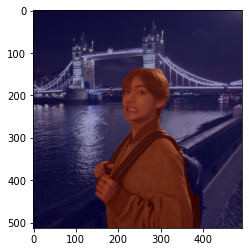

In [60]:
def person_img(img_resized, seg_map, label):
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    return img_mask

img_mask1 = person_img(img1_resized, seg_map1, 15)

15를 가진 영역(사람의 영역)이 주황색으로 칠해진 것을 확인하실수 있습니다. 

### 2.5 세그멘테이션 결과를 원래 크기로 복원하기

DeepLap 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력해야합니다.  
세그멘테이션 결과를 원래 크기로 복원하도록 하겠습니다.

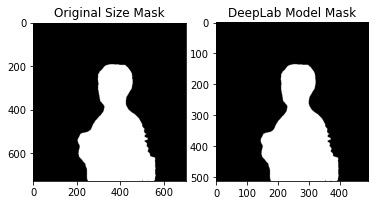

In [61]:
def resize_person_img(img_orig, img_mask):
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    return img_mask_up
    
img1_mask_up = resize_person_img(img1_orig, img_mask1)

위 사진의 좌표축의 값을 보면 원본사진의 크기와 모델입력사진의 크기가 다른 것을 확인하실 수 있습니다.

### 2.6 배경 흐리게 하기

세그멘테이션 마스크를 이용해서 배경만 추출하도록 하겠습니다.  

`bitwise_not` 함수를 이용하면 이미지가 반전됩니다.  
`bitwise_and` 함수를 수행하면 배경만 있는 영상을 얻을 수 있습니다.

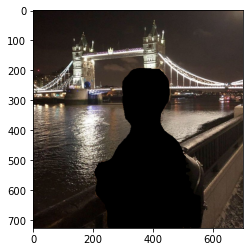

In [62]:
def backgroud_img(img_orig, img_mask_up):
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_mask_color, img_bg

img1_mask_color, img1_bg = backgroud_img(img1_orig, img1_mask_up)

원본 이미지와 마스크 이미지를 사용하여 배경만 추출한 것을 확인하실 수 있습니다.

배경만 있는 이미지를 불러 blur 처리를 합니다.

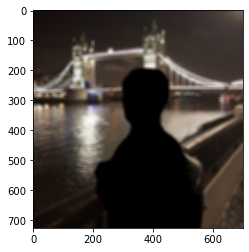

In [63]:
def backgroud_blur_img(img_bg):
    img_bg_blur = cv2.blur(img_bg, (13,13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_bg_blur

img1_bg_blur = backgroud_blur_img(img1_bg)

배경만 추출한 사진을 블러처리한 것을 확인하실 수 있습니다.

### 2.7 흐린 배경과 원본 영상 합성

흐린 배경 이미지와 사람 이미지를 합쳐보도록 하겠습니다. 

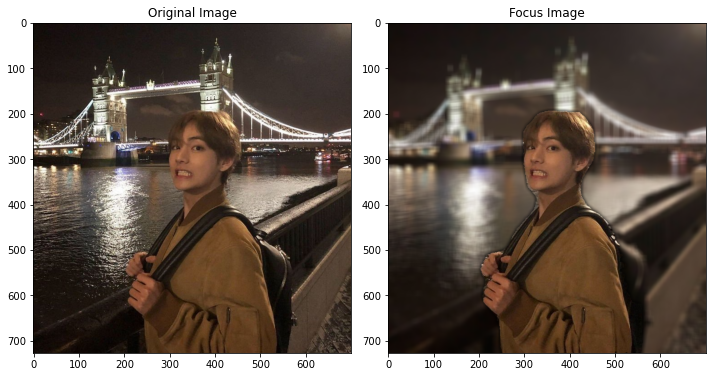

In [64]:
def focus_img(img_orig, img_bg_blur, img_mask_color, img_save):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')

    ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Focus Image')

    fig.tight_layout()
    plt.show()
    
    cv2.imwrite('{}/{}.jpg'.format(img_path, img_save), img_concat)
    
    return img_concat

img1_concat = focus_img(img1_orig, img1_bg_blur, img1_mask_color, 'V_focus')

최종적으로 원본사진을 아웃포커싱 사진으로 변경하였습니다. :)

### 2.8 전체적인 함수 흐름

전체적인 함수 흐름은 아래 그림과 같습니다. 다음 응용문제에 적용하기 위해서 한눈에 보기 쉽게 정리하였습니다.
<img src="1.png" width="700">
<img src="2.png" width="700">
<img src="3.png" width="700">
<img src="4.png" width="700">
<img src="5.png" width="700">
<img src="6.png" width="700">

## 3 비숑(강아지) 에 대한 아웃포커싱 사진 만들기

- 비숑 이미지 읽어오기

In [65]:
img2_orig = cv2.imread(img_path + '/dog.jpeg')

print(f'dog_orig shape : {img2_orig.shape}')

dog_orig shape : (540, 540, 3)


- 비숑 이미지 전처리하기

In [66]:
img2_resized, seg_map2 = MODEL.run(img2_orig)

print(f'dog_orig shape : {img2_orig.shape}, dog_resized : {img2_resized.shape}, dog_seg_map : {np.unique(seg_map2)}')

dog_orig shape : (540, 540, 3), dog_resized : (513, 513, 3), dog_seg_map : [ 0 12 15]


- 강아지 라벨 확인하기

In [67]:
print(LABEL_NAMES[0])
print(LABEL_NAMES[12])
print(LABEL_NAMES[15])

background
dog
person


- 강아지 이미지에서 12를 가진 영역(강아지의 영역)만 검출하기

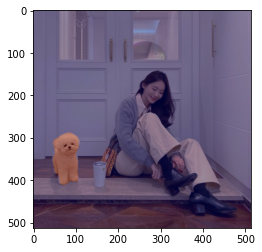

In [69]:
img2_mask= person_img(img2_resized, seg_map2, 12)

- 세그멘테이션 크기 복원하기

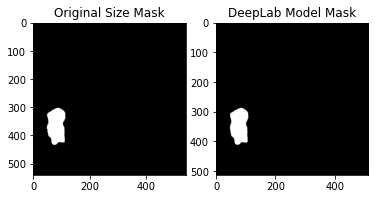

In [70]:
img2_mask_up = resize_person_img(img2_orig, img2_mask)

- 배경만 추출하기

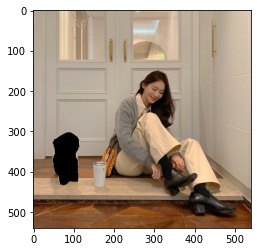

In [71]:
img2_mask_color, img2_bg = backgroud_img(img2_orig, img2_mask_up)

- 배경 블러처리하기

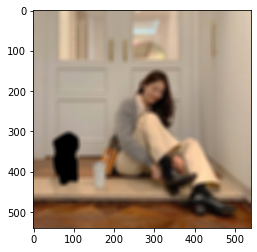

In [72]:
img2_bg_blur = backgroud_blur_img(img2_bg)

- 아웃포커싱 사진 만들기 (블러 배경 + 원본 이미지)

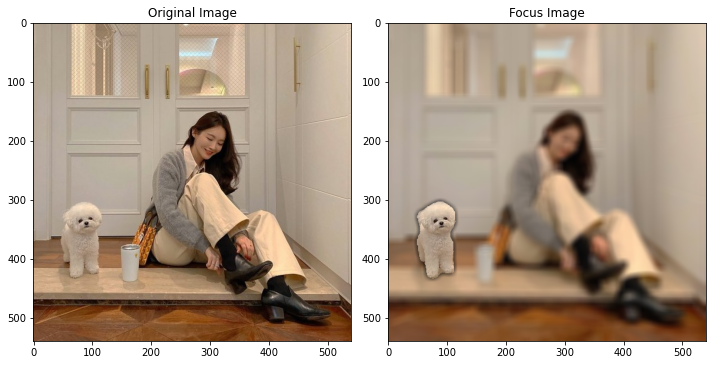

In [73]:
img2_concat = focus_img(img2_orig, img2_bg_blur, img2_mask_color, 'dog_focus')

## 4 배경사진을 다른 이미지로 교체하기

- 사진 이미지와 배경 이미지 읽어오기

In [88]:
img3_orig = cv2.imread(img_path + '/V02.jpg')
bg_orig = cv2.imread(img_path + '/wing.png')

print(f'img3_orig shape : {img3_orig.shape}')
print(f'bg_orig shape : {bg_orig.shape}')

img3_orig shape : (960, 640, 3)
bg_orig shape : (500, 499, 3)


- 사진 이미지 전처리하기

In [89]:
img3_resized, seg_map3 = MODEL.run(img3_orig)
bg_resize = cv2.resize(bg_orig, (640, 960))

print(f'img3_orig shape : {img3_orig.shape}, img3_resized : {img3_resized.shape}, seg_map3 : {np.unique(seg_map3)}')
print(f'bg_orig shape : {bg_orig.shape}, bg_resize : {bg_resize.shape}')

img3_orig shape : (960, 640, 3), img3_resized : (513, 342, 3), seg_map3 : [ 0 15]
bg_orig shape : (500, 499, 3), bg_resize : (960, 640, 3)


- 사람 라벨 확인하기

In [90]:
print(LABEL_NAMES[0])
print(LABEL_NAMES[15])

background
person


- 사진 이미지에서 15를 가진 영역(사람의 영역)만 검출하기

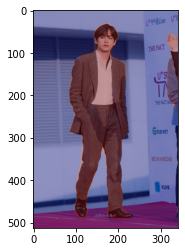

In [91]:
img3_mask = person_img(img3_resized, seg_map3, 15)

- 세그멘테이션 크기 복원하기

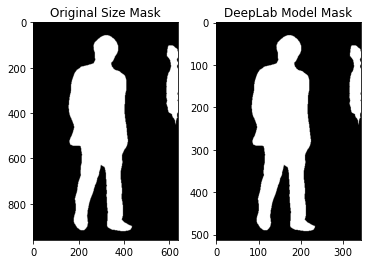

In [92]:
img3_mask_up = resize_person_img(img3_orig, img3_mask)

- 인물만 추출하기

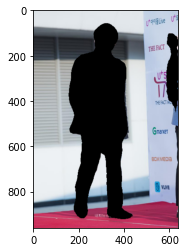

In [93]:
img3_mask_color, _ = backgroud_img(img3_orig, img3_mask_up)

- 배경 합성하기

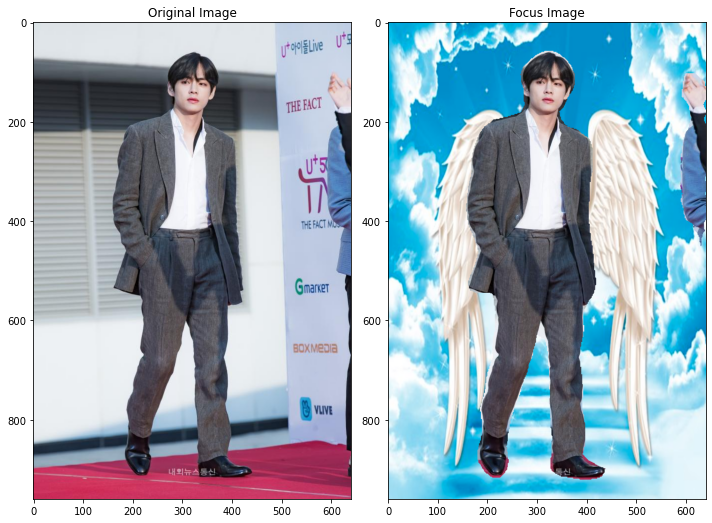

In [94]:
img1_concat = focus_img(img3_orig, bg_resize, img3_mask_color, 'V_background')

## 5 사진에서 문제점 찾기

### 5.1 인물 포커스 사진 문제점

사람이 메고 있는 가방이 인물 영역에 포함되지 않아 blur되서 나왔습니다.
<img src="7.png" width="700">

### 5.2 비숑 포커스 사진 문제점

문제점이 없어보입니다.
<img src="8.png" width="700">

### 5.3 배경 합성 사진 문제점

추출하고자 하는 인물외의 다른 인물도 포함되었습니다. 그래서 배경합성을 할때, 같이 포함되어 나옵니다.
<img src="9.png" width="700">

## 6 해결 방법을 제안해 보기

단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 6.1 인물 포커스 사진 문제 해결 방법 제안하기

사람이 메고 있는 가방이 인물 영역에 포함되지 않아 blur되서 나왔습니다. 가방을 포함시키기 위해서는 Struct2Depth 을 이용하면 됩니다.  
Struct2Depth는 이미지에서 depth을 계산하는데 이를 이용하면 인물의 거리와 비슷한 것들을 포함시키고,  
인물의 거리와 먼 것은 모두 제외시켜 시그멘테이션하면 가방도 포함시킬 수 있습니다.

### 6.2 배경 합성 사진 문제 해결 방법 제안하기

추출하고자 하는 인물외의 다른 인물도 포함되었습니다. 그래서 배경합성을 할때 다른 인물도 같이 포함되어 나옵니다.  
이를 해결하기 위해서는 사람을 분리할때, semantic segmentation 기법이 아닌 instance segmentation 기법을 사용하여 사람을 추출합니다.  
instance segmentation 기법을 사용하면 사람 개개인 별로 다른 라벨을 가지게 되므로, 원하고자 하는 사람의 라벨만 사용해서 배경을 합성하면 됩니다.

# [ 결과 - 루브릭 ]
**1. 인물모드 사진을 성공적으로 제작하였다.**
- 아웃포커싱 효과가 적용된 인물모드 사진과 강아지 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였습니다. :)  

**2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.** 
- 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였습니다. :)
  
**3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.**
- 인물모드 사진의 문제점을 개선할 수 있는 좋은 솔루션을 구체적으로 제시하였다. :)
